### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pandas_profiling
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBBBS'
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12376
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|    10|[80 49 40 4C E0 D...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     1|[30 54 40 4C A0 D...|1950.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 C9 40 4C 40 5...|1951.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[E0 D4 30 D5 F0 D...|1952.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 4D 80 4D A0 5...|1953.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
# import pandas_profiling
pandas_df = df.toPandas()
pandas_df_1 = pandas_df.drop('vector', axis=1)
pandas_profiling.ProfileReport(pandas_df_1)


Number of variables,8
Number of observations,12376
Total Missing (%),0.0%
Total size in memory,773.6 KiB
Average record size in memory,64.0 B
Numeric,5
Categorical,2
Date,0
Text (Unique),0
Rejected,1
Distinct count,86


In [3]:
snwd = STAT['SNWD']
print type(snwd)
print snwd.keys()
# snwd_df = pd.DataFrame.from_dict(snwd)

<type 'dict'>
['std', 'UnDef', 'E', 'Cov', 'high1000', 'NE', 'O', 'low100', 'NO', 'high100', 'eigvec', 'low1000', 'Var', 'eigval', 'mean', 'SortedVals', 'Mean']


### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement = '%s' and station = '%s'"%('SNWD','USC00105980')
# Query="SELECT * FROM weather\n\tWHERE measurement = '%s' and station = '%s'"%('SNWD','USC00198301')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling two make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement = 'SNWD' and station = 'USC00105980'
49 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       SNWD|USC00105980|     0|[58 5A 58 5A 58 5...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       SNWD|USC00105980|     1|[40 4E 60 52 60 5...|1950.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(49, 365)

In [5]:
Query="SELECT * FROM weather\n\tWHERE measurement = '%s'"%('TOBS')
print Query
dftobs = sqlContext.sql(Query)
print dftobs.count(),'rows'
dftobs.show(2)
rows=dftobs.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling two make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement = 'TOBS'
1866 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       TOBS|USC00105980|    30|[80 D1 00 7E 00 7...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TOBS|USC00105980|     1|[80 54 00 4F E0 5...|1963.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(1866, 365)

In [6]:
dftobs = dftobs.toPandas()

In [12]:
max_tobs = np.nanmax(T, axis=1)
print len(max_tobs)
dftobs_1 = dftobs[['year']]
dftobs_1['temp'] = max_tobs
print dftobs_1.head()

1866
     year      temp
0  1949.0  36.09375
1  1963.0  35.00000
2  1964.0  37.18750
3  1965.0  34.40625
4  1966.0  34.40625


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
dftobs_mean = dftobs_1.groupby('year').sum().reset_index().groupby('year').mean()

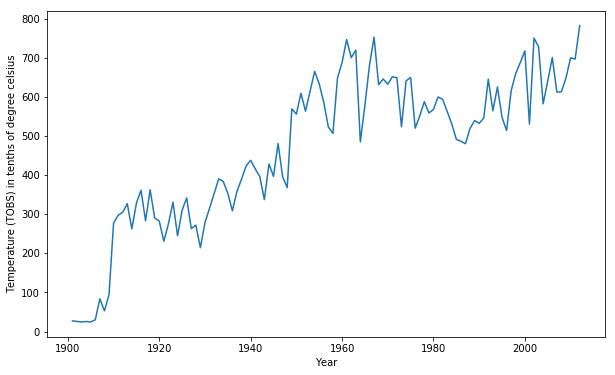

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Temperature (TOBS) in tenths of degree celsius")
plt.plot(dftobs_mean)


### Script for plotting yearly plots

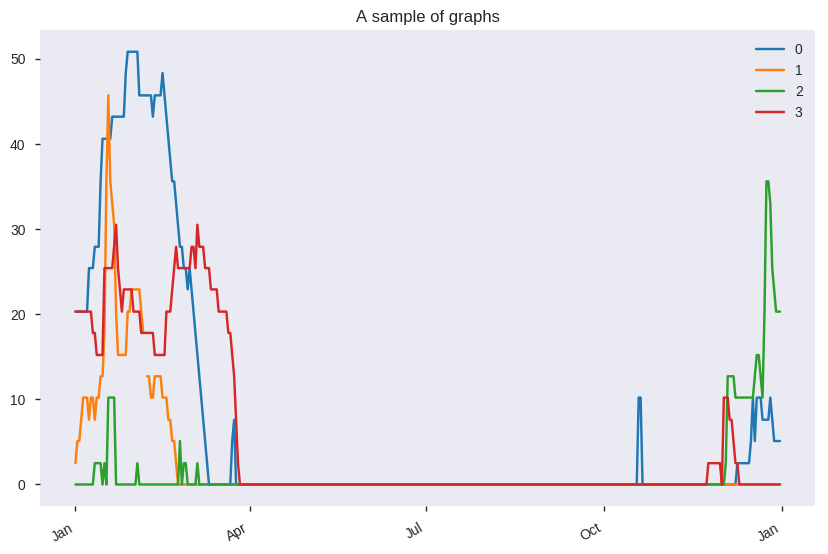

In [6]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:4,:].transpose(),fig,ax,title='PRCP')
title('A sample of graphs');


### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [7]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
#     fig.autofmt_xdate()
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


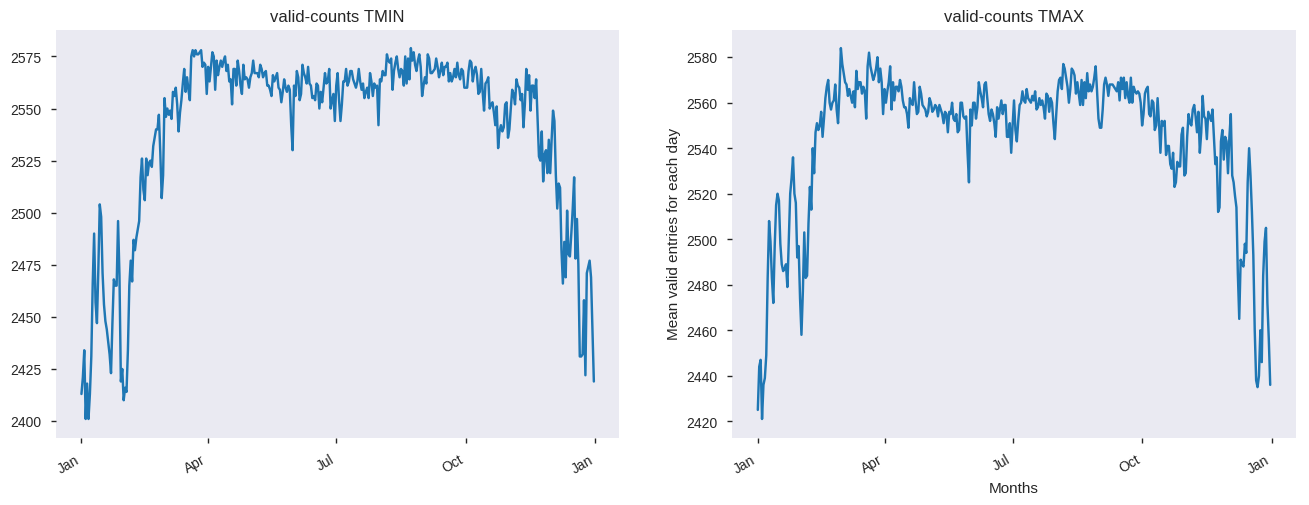

In [8]:
plot_pair(['TMIN','TMAX'],plot_valid)
xlabel("Months")
ylabel("Mean valid entries for each day")

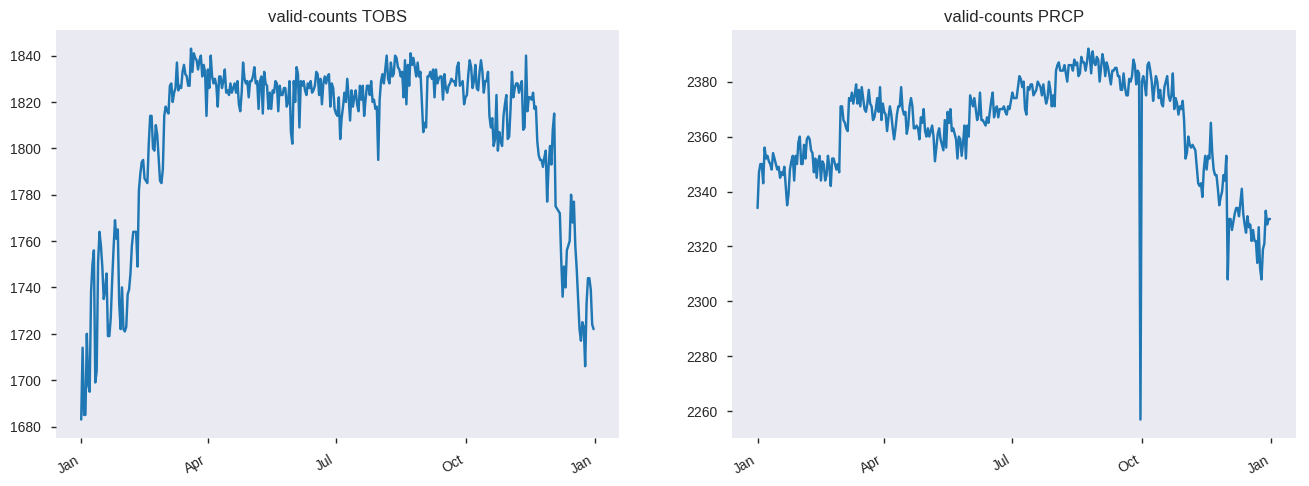

In [9]:
plot_pair(['TOBS','PRCP'],plot_valid)

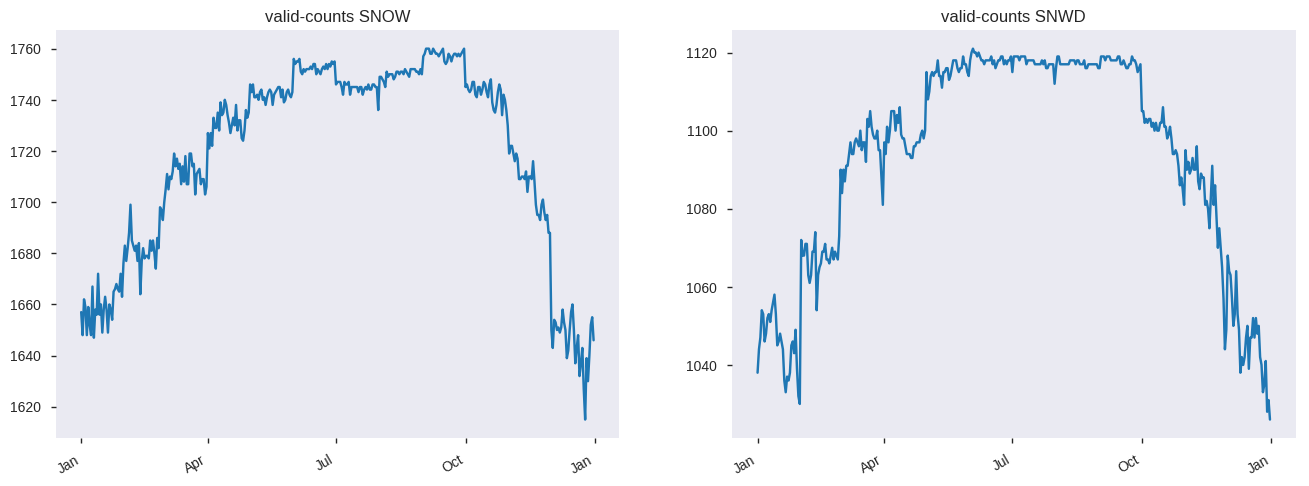

In [10]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [11]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

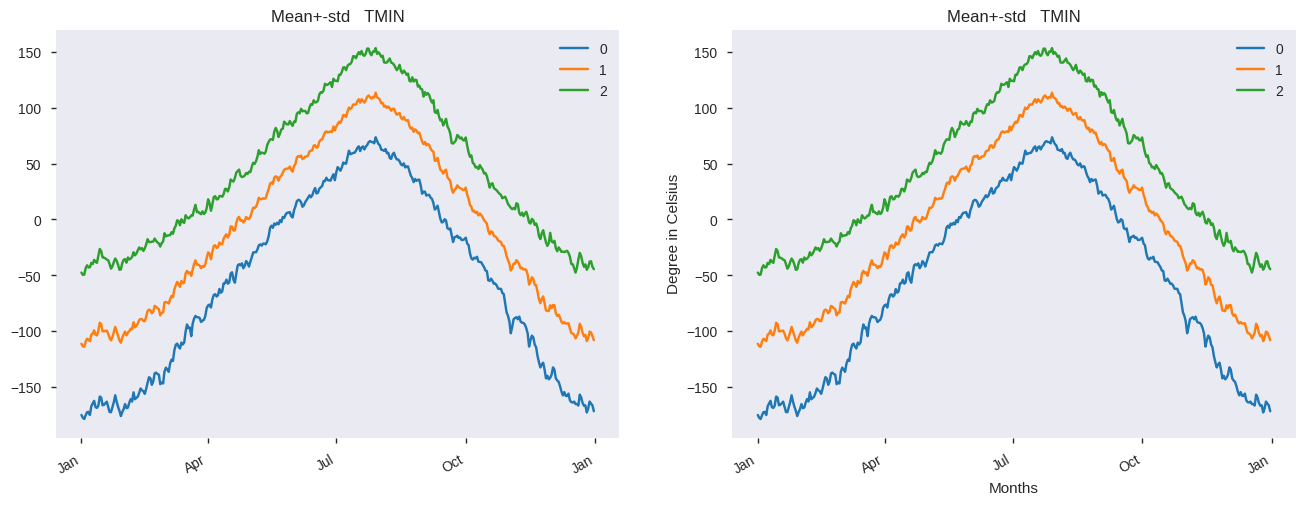

In [12]:
plot_pair(['TMIN','TMIN'],plot_mean_std)
xlabel("Months");
ylabel("Degree in Celsius");

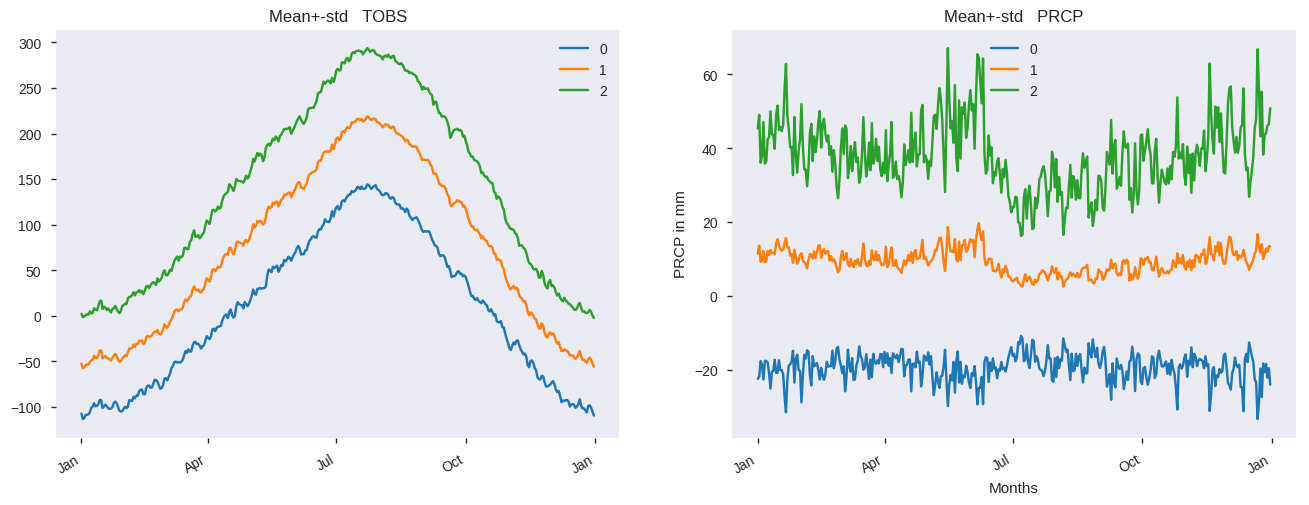

In [13]:
plot_pair(['TOBS','PRCP'],plot_mean_std)
xlabel("Months");
ylabel("PRCP in mm");

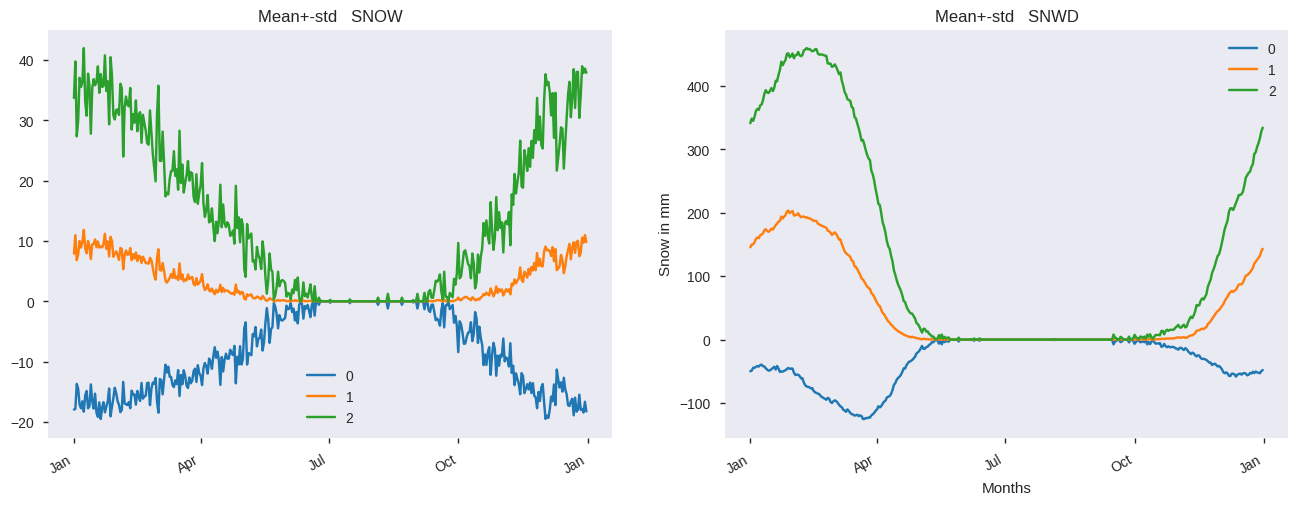

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)
xlabel("Months");
ylabel("Snow in mm");

In [15]:
mean_prcp = STAT['PRCP']['Mean']
print np.mean(mean_prcp)

9.31160968776


### plotting top 3 eigenvectors

In [16]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

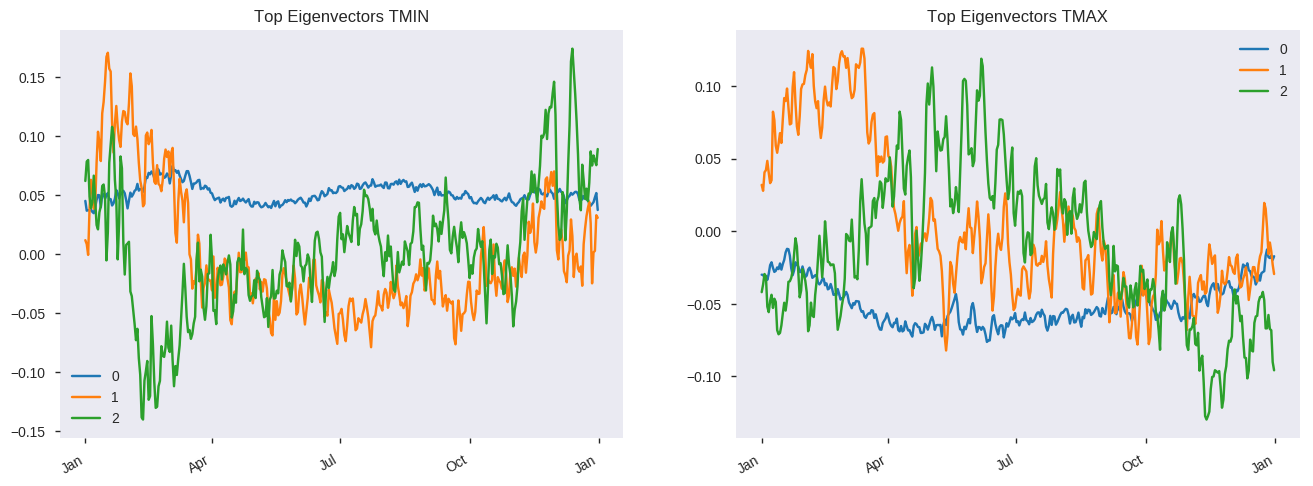

In [17]:
plot_pair(['TMIN','TMAX'],plot_eigen)

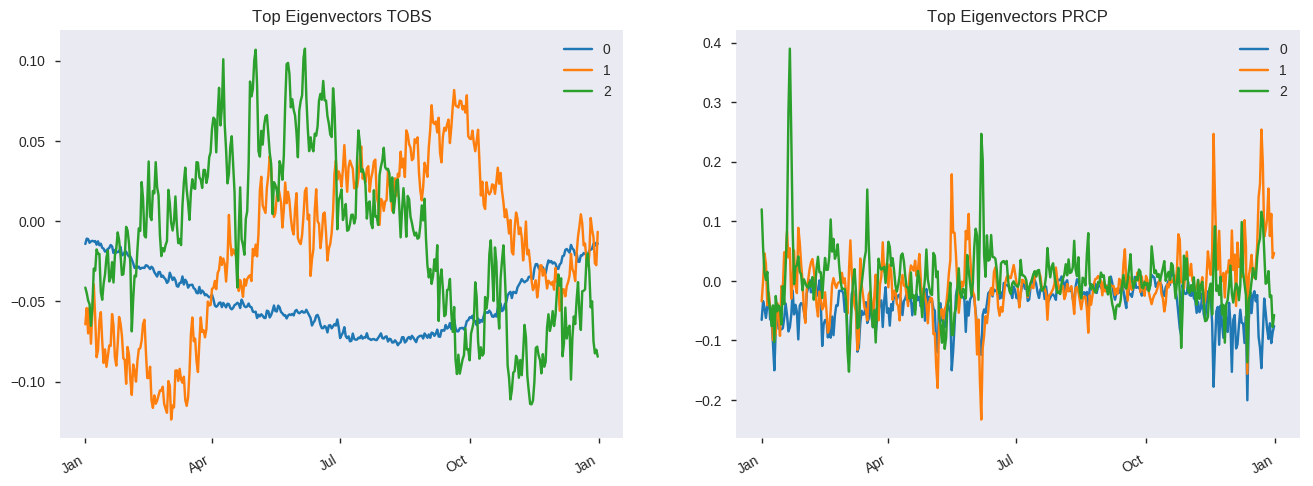

In [18]:
plot_pair(['TOBS','PRCP'],plot_eigen)

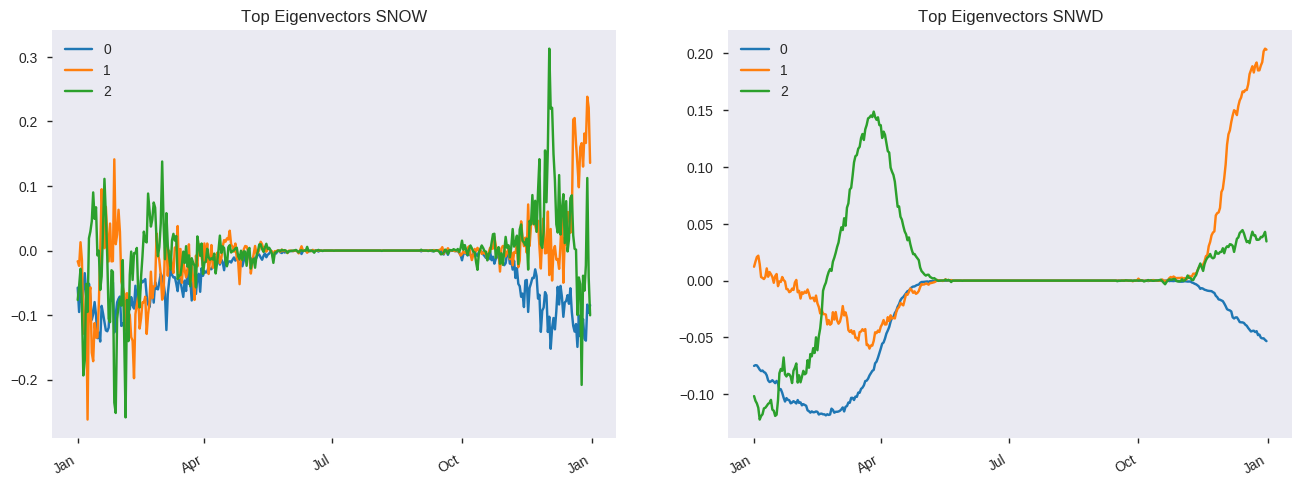

In [19]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [20]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

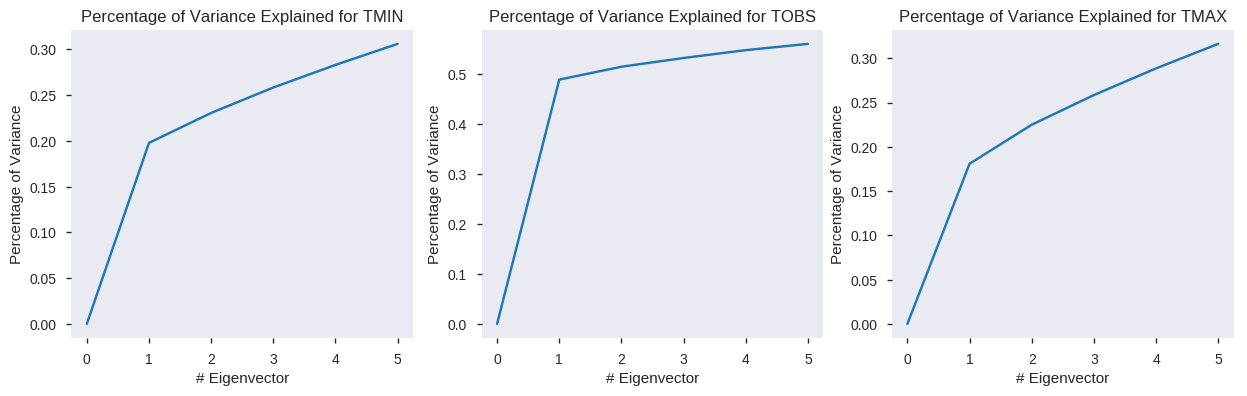

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

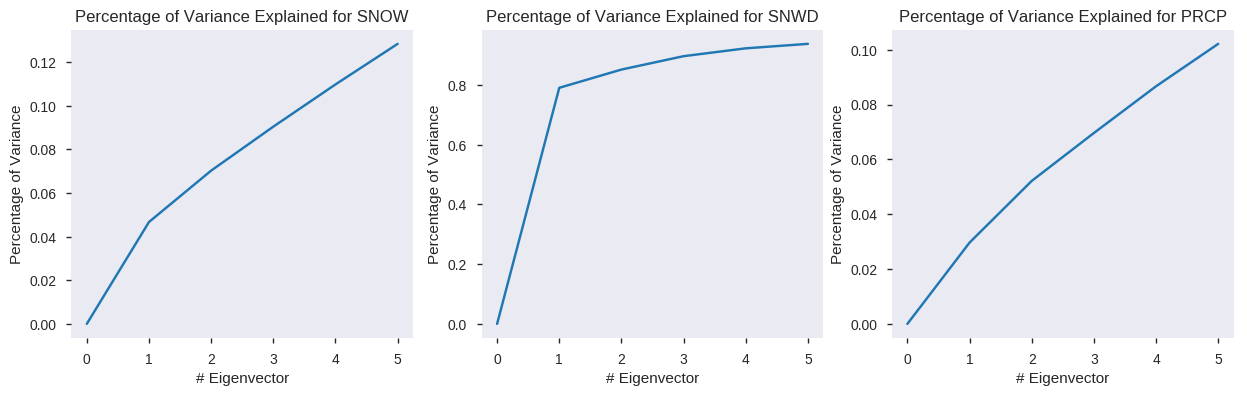

In [22]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [24]:
sc.stop()